In [1]:
import os
import pandas as pd 
import numpy as np
import sys
import seaborn as sb
import tensorflow as tf 
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
batch_size = 40
img_height = 200
img_width = 200

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Thesis_Code/Rice plant',
    validation_split=0.1,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 819 files belonging to 2 classes.
Using 738 files for training.


In [5]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/drive/MyDrive/Thesis_Code/Rice plant',
    validation_split=0.1,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

class_names = training_ds.class_names

Found 821 files belonging to 2 classes.
Using 82 files for validation.


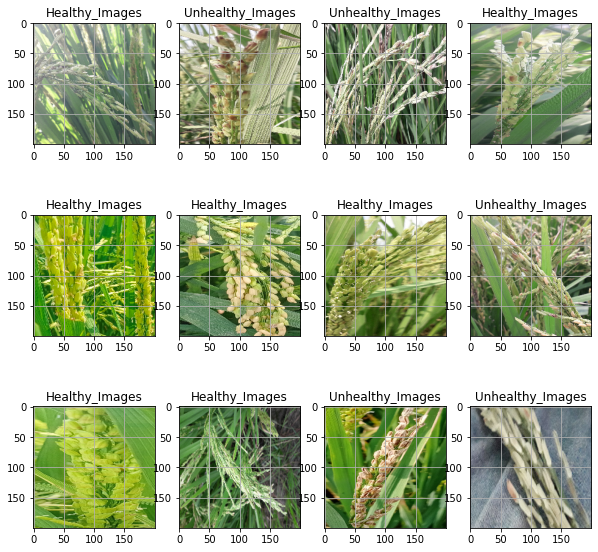

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

Text(0.5, 1.0, 'healthy vs Unhealthy samples in data set')

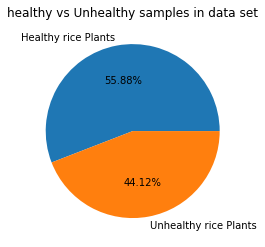

In [7]:
healthy = os.listdir('/content/drive/MyDrive/Thesis_Code/Rice plant/Healthy_Images')
unhealthy = os.listdir('/content/drive/MyDrive/Thesis_Code/Rice plant/Unhealthy_Images')
plt.pie ([len(healthy), len(unhealthy)], labels = ['Healthy rice Plants', 
                                                                      'Unhealthy rice Plants'],autopct='%1.2f%%')
plt.title('healthy vs Unhealthy samples in data set')

In [8]:
## defining data augumentation layer
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  
  
])

In [9]:
## ## lets define our CNN
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(1, activation= 'sigmoid')
])


MyCnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
## rescheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
## training our model 
retVal = MyCnn.fit(training_ds, validation_data= testing_ds,callbacks=[callback], epochs = 14)

Epoch 1/14
19/19 [==============================] - 111s 5s/step - loss: 1.0479 - accuracy: 0.5691 - val_loss: 0.7469 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 2/14
19/19 [==============================] - 81s 4s/step - loss: 0.6553 - accuracy: 0.5976 - val_loss: 0.5884 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 3/14
19/19 [==============================] - 82s 4s/step - loss: 0.6050 - accuracy: 0.6450 - val_loss: 0.6441 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 4/14
19/19 [==============================] - 82s 4s/step - loss: 0.6060 - accuracy: 0.6585 - val_loss: 0.5607 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 5/14
19/19 [==============================] - 81s 4s/step - loss: 0.5689 - accuracy: 0.6775 - val_loss: 0.6623 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 6/14
19/19 [==============================] - 83s 4s/step - loss: 0.5269 - accuracy: 0.7154 - val_loss: 0.5623 - val_accuracy: 0.6707 - lr: 9.0484e-04
Epoch 7/14
19/19 [==============================] - 93s 4s/step - loss: 0.456

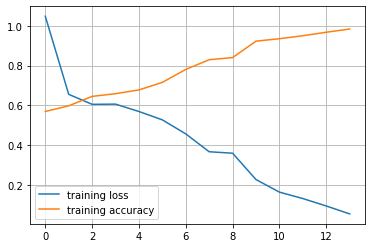

In [12]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.grid(True)

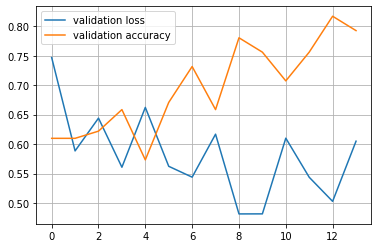

In [13]:
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.grid(True)

2/2 [==============================] - 1s 186ms/step


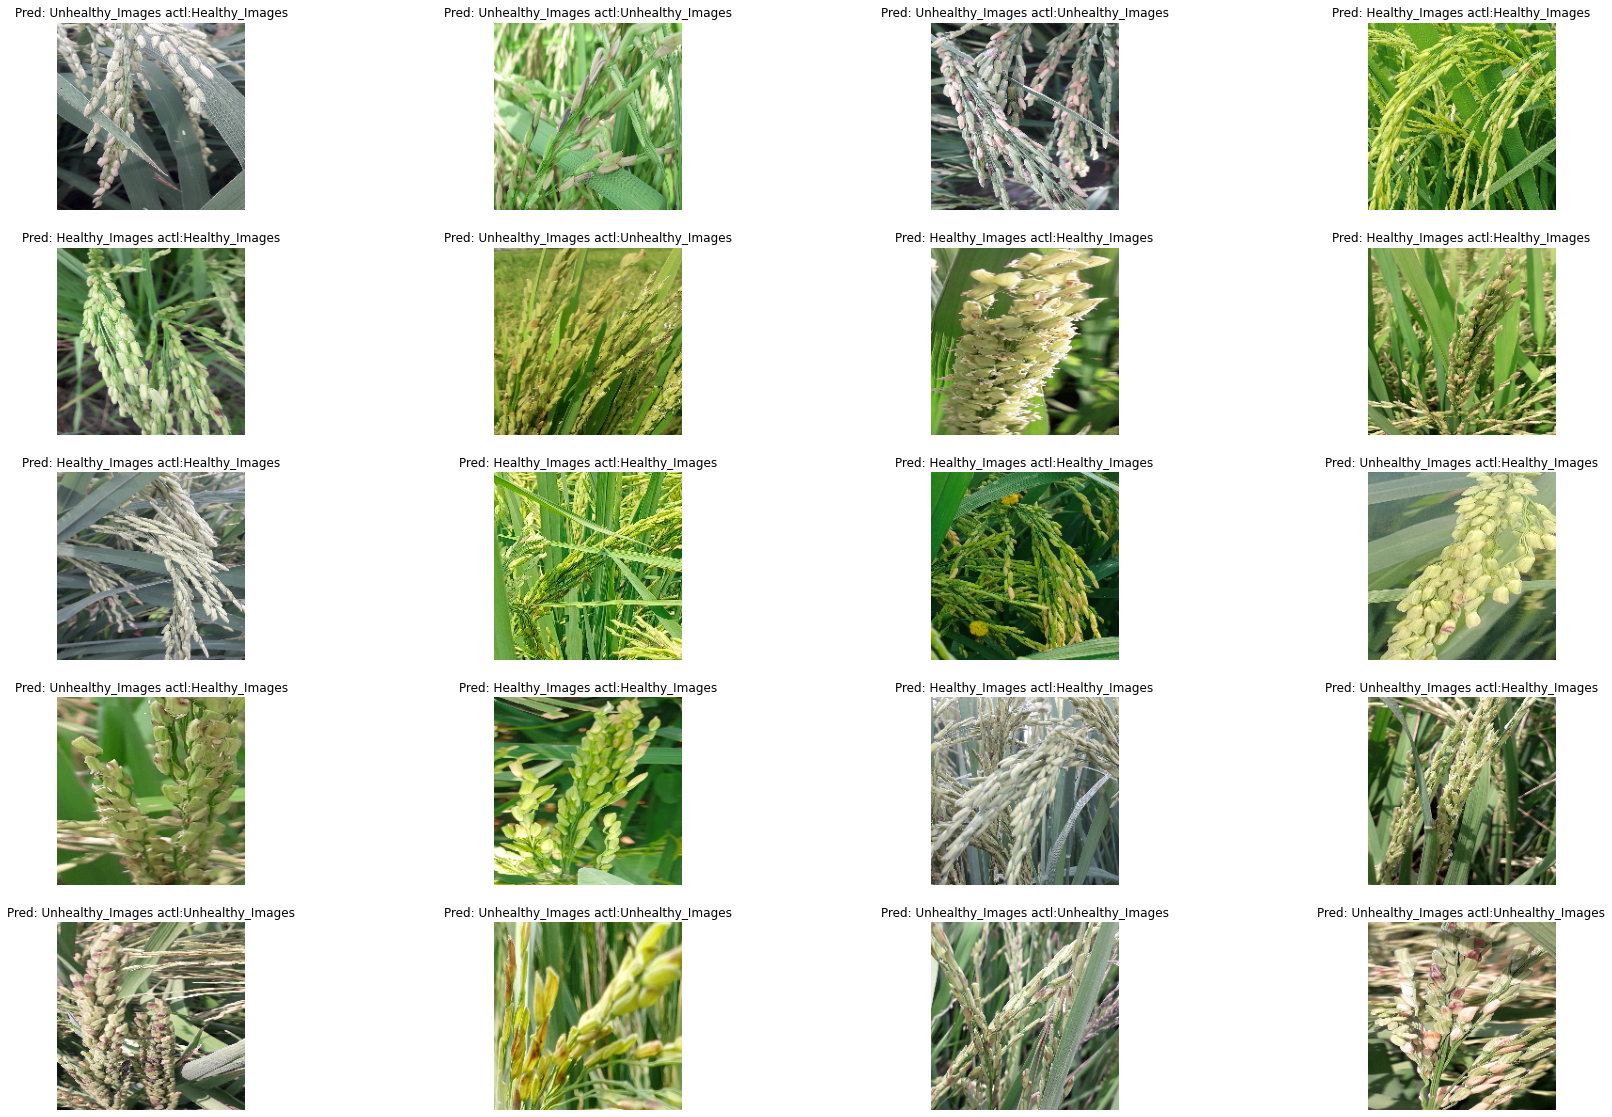

In [14]:
AccuracyVector = []
plt.figure(figsize=(30, 20))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[int (round(mem[0]))])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

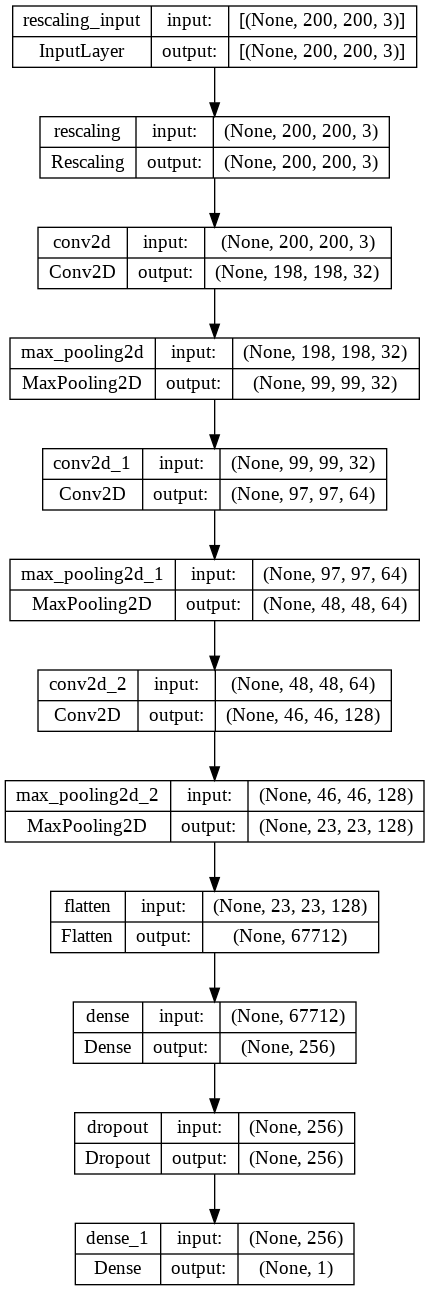

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [16]:
MyCnn.save('model1.h5')